
# OpenSR QA1/QA2 필터 (DISK + LightGlue) — 노트북 버전

이 노트북은 **OpenSR** 논문 기준(지상 기준점 정합 + 방사 매칭)으로 HR/LR 페어를 자동 평가해서 **bad sample**을 걸러냅니다.

- **QA1(정합)**: **DISK** 키포인트 + **LightGlue** 매칭 → **RANSAC 유사변환** → HR 해상도 기준 **RMSE(미터)** 계산 → `0.75 m` 이하 **PASS**  
- **QA2(방사)**: RANSAC으로 **LR→GT 워핑** → **밴드별 히스토그램 매칭** → **스펙트럼 각도(SAM)** 평균 **deg** 계산 → `5°` 이하 **PASS**  
- 두 기준 모두 PASS면 `good`, 하나라도 실패하면 `drop`

**폴더 구조**
```
BASE_DIR/<split>/{LR,GT}/filename.png
```
예) `../versions/zero_cloud_pairs/train/LR/xxx.png`, `.../train/GT/xxx.png`

**참고 레포**
- LightGlue: https://github.com/cvg/LightGlue  
- DISK: https://github.com/cvlab-epfl/disk

> 임계값은 OpenSR 문구: *“변위 오류가 0.75m를 초과하면 폐기, 스펙트럼 각도(SAD) 5° 임계값”* 에 맞춰 설정되어 있습니다.



## 0. 환경 설정

아래 셀을 **한 번만** 실행해 의존성을 설치하세요. (런타임 재시작 필요할 수 있음)

- CUDA가 있다면 PyTorch는 **CUDA 빌드**로 설치하세요. (경우에 따라 인덱스 URL 수정)
- LightGlue는 레포 그대로 설치합니다. (DISK 추출기도 `lightglue.DISK`로 바로 사용 가능)

> **Windows PowerShell**에서 실행 시 `pip` 대신 `python -m pip` 사용을 권장합니다.


In [1]:
import torch
print(torch.__version__)                # torch 버전
print("cuda available:", torch.cuda.is_available())
print("cuda version:", torch.version.cuda)
print("device count:", torch.cuda.device_count())
print("device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")


2.4.1+cu124
cuda available: True
cuda version: 12.4
device count: 1
device name: NVIDIA GeForce RTX 4090


In [2]:

# 선택 1) 권장: 깃에서 바로 설치(간단)
# 런타임/머신 환경에 맞춰 torch를 먼저 설치하세요.
# 예시(CUDA 12.1용 휠; 환경에 맞게 교체):
#%pip install --upgrade pip
#%pip install --extra-index-url https://download.pytorch.org/whl/cu121 torch torchvision torchaudio
#%pip install opencv-python scikit-image pandas tqdm
#%pip install --no-build-isolation --no-deps git+https://github.com/cvg/LightGlue.git

# 선택 2) 로컬 클론 후 개발 모드 설치
# !git clone https://github.com/cvg/LightGlue.git
# %pip install -e LightGlue

# 설치 검증
import torch, cv2, pandas, skimage, lightglue
print("torch:", torch.__version__, "| cuda:", torch.cuda.is_available())
print("OpenCV:", cv2.__version__)
import lightglue
print("lightglue OK")


torch: 2.4.1+cu124 | cuda: True
OpenCV: 4.12.0
lightglue OK


## 1. 임포트 & 공용 설정

In [3]:

from __future__ import annotations

import math
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
from skimage.exposure import match_histograms

import torch
torch.set_grad_enabled(False)

# LightGlue / DISK
from lightglue import LightGlue, DISK
from lightglue.utils import rbd  # remove batch dimension helper

# === 사용자 경로/설정 ===
BASE_DIR = Path("./zero_cloud_pairs")  # 필요 시 수정
SPLITS = ["train", "val", "test"]               # 예: ["train"]
HR_GSD_MPP = 2.5    # HR 그라운드 해상도: meters per pixel (예: SPOT 6/7 ~1.5m/px)
LR_GSD_MPP = 10.0   # (정보용) Sentinel-2 ~10m/px

# 품질 임계값 (OpenSR 문구를 그대로 반영)
QA1_THRESH_M = 0.75  # RMSE[m] <= 0.75
QA2_THRESH_DEG = 5.0 # SAM mean[deg] <= 5°

# 러닝 파라미터
MAX_KP = 2048                # DISK 최대 키포인트 개수
DISP_MAX_LR_PX = 3.0       # 오매칭 제거 게이트: 3 LR px (≈30m)
RANSAC_REPROJ_THRESH_PX = DISP_MAX_LR_PX * (LR_GSD_MPP / HR_GSD_MPP)
RESIZE_LR_TO_GT = True       # 매칭 전 LR을 GT 크기로 보간
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

OUT_CSV = Path("opensr_qc_result.csv")
MOVE_MODE = "copy"  # ["none", "copy", "move"]


## 2. 유틸 함수 (이미지 입출력, 정합/방사 계산)

In [4]:

def to_tensor_image(img_bgr: np.ndarray, device: torch.device) -> torch.Tensor:
    """cv2 BGR uint8 -> torch.FloatTensor [3,H,W] in [0,1], RGB 순서"""
    if img_bgr.ndim == 2:
        img_bgr = cv2.cvtColor(img_bgr, cv2.COLOR_GRAY2BGR)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    ten = torch.from_numpy(img_rgb).permute(2, 0, 1).float() / 255.0
    return ten.to(device, non_blocking=True)


def estimate_similarity_ransac(src_pts: np.ndarray, dst_pts: np.ndarray,
                               ransac_thresh_px: float = 3.0, max_iters: int = 2000) -> Tuple[Optional[np.ndarray], Optional[np.ndarray]]:
    """
    src_pts (N,2) -> dst_pts (N,2) 유사변환(회전/이동/스케일) RANSAC 추정
    반환: (2x3 affine matrix, inlier mask[bool])
    """
    if len(src_pts) < 4:
        return None, None
    M, inliers = cv2.estimateAffinePartial2D(
        src_pts, dst_pts, method=cv2.RANSAC,
        ransacReprojThreshold=ransac_thresh_px,
        maxIters=max_iters, confidence=0.999
    )
    if M is None or inliers is None:
        return None, None
    inliers = inliers.ravel().astype(bool)
    return M, inliers


def apply_affine(img: np.ndarray, M: np.ndarray, out_hw: Tuple[int, int]) -> np.ndarray:
    """2x3 Affine 행렬로 img를 워핑 (out_hw: (H,W))"""
    H, W = out_hw
    return cv2.warpAffine(img, M, (W, H), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT101)


def rmse_in_meters(residual_px: np.ndarray, meters_per_px: float) -> float:
    """픽셀 단위 잔차 → 미터 RMSE"""
    if residual_px.size == 0:
        return float('inf')
    return float(np.sqrt(np.mean(np.square(residual_px * meters_per_px))))


def spectral_angle_degrees(a_rgb: np.ndarray, b_rgb: np.ndarray, eps: float = 1e-8, clip_valid: bool = True) -> float:
    """
    SAM/SAD: 각 픽셀 벡터 간 각도(도 단위)의 평균.
    a_rgb, b_rgb: uint8 or float32, [H,W,3], 같은 프레임/해상도
    """
    a = a_rgb.astype(np.float32)
    b = b_rgb.astype(np.float32)

    A = a.reshape(-1, 3)
    B = b.reshape(-1, 3)

    na = np.linalg.norm(A, axis=1)
    nb = np.linalg.norm(B, axis=1)
    if clip_valid:
        valid = (na > eps) & (nb > eps)
        if not np.any(valid):
            return 180.0
        A = A[valid]; B = B[valid]
        na = na[valid]; nb = nb[valid]

    cosang = np.sum(A * B, axis=1) / (na * nb + eps)
    cosang = np.clip(cosang, -1.0, 1.0)
    ang = np.degrees(np.arccos(cosang))
    return float(np.mean(ang))


def hist_match_per_band(src_rgb: np.ndarray, ref_rgb: np.ndarray) -> np.ndarray:
    """밴드별 히스토그램 매칭"""
    matched = match_histograms(src_rgb, ref_rgb, channel_axis=-1)
    return matched


def ensure_pair_paths(base: Path, split: str, filename: str) -> Tuple[Path, Path]:
    """split/GT/filename, split/LR/filename 경로 리턴"""
    gt = base / split / "GT" / filename
    lr = base / split / "LR" / filename
    return gt, lr


def safe_imread(path: Path) -> np.ndarray:
    img = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Failed to read image: {path}")
    return img


def list_filenames(base: Path, split: str) -> List[str]:
    lr_dir = base / split / "LR"
    if not lr_dir.exists():
        return []
    return sorted([p.name for p in lr_dir.glob("*.png")])


def make_out_dirs(base: Path, split: str):
    root = base / "filtered" / split
    good_lr = root / "good" / "LR"
    good_gt = root / "good" / "GT"
    drop_lr = root / "drop" / "LR"
    drop_gt = root / "drop" / "GT"
    for d in [good_lr, good_gt, drop_lr, drop_gt]:
        d.mkdir(parents=True, exist_ok=True)
    return {"good_lr": good_lr, "good_gt": good_gt, "drop_lr": drop_lr, "drop_gt": drop_gt}


def move_or_copy_pair(mode: str, src_lr: Path, src_gt: Path, dst_dirs, do_move: bool):
    """mode in {'good','drop'}"""
    dst_lr = dst_dirs[f"{mode}_lr"] / src_lr.name
    dst_gt = dst_dirs[f"{mode}_gt"] / src_gt.name
    data_lr = src_lr.read_bytes()
    data_gt = src_gt.read_bytes()
    dst_lr.write_bytes(data_lr)
    dst_gt.write_bytes(data_gt)
    if do_move:
        try:
            src_lr.unlink(missing_ok=True)
            src_gt.unlink(missing_ok=True)
        except Exception:
            pass


## 3. 한 페어 평가 (QA1/QA2)

In [5]:
def evaluate_pair(
    extractor: DISK,
    matcher: LightGlue,
    img_lr_bgr: np.ndarray,
    img_gt_bgr: np.ndarray,
    hr_mpp: float,
    lr_mpp: float = 10.0,           # Sentinel-2 LR 해상도 [m/px]
    resize_lr_to_gt: bool = True,
    ransac_thresh_px: float = None, # 자동으로 계산됨
) -> Dict[str, float]:
    """
    한 페어에 대해 QA1/QA2 지표 계산 (OpenSR 논문 규칙 반영).
     - QA1: RMSE in LR pixels (<=0.75 px)
     - QA2: Spectral Angle Distance (<=5°)
    """
    Ht, Wt = img_gt_bgr.shape[:2]
    img_lr = img_lr_bgr
    if resize_lr_to_gt and (img_lr_bgr.shape[:2] != img_gt_bgr.shape[:2]):
        img_lr = cv2.resize(img_lr_bgr, (Wt, Ht), interpolation=cv2.INTER_LINEAR)

    device = next(matcher.parameters()).device
    ten_lr = to_tensor_image(img_lr, device)
    ten_gt = to_tensor_image(img_gt_bgr, device)

    feats_lr = extractor.extract(ten_lr)
    feats_gt = extractor.extract(ten_gt)

    matches_lr_gt = matcher({'image0': feats_lr, 'image1': feats_gt})
    feats_lr, feats_gt, matches_lr_gt = [rbd(x) for x in [feats_lr, feats_gt, matches_lr_gt]]
    m = matches_lr_gt['matches']
    kps_lr = feats_lr['keypoints'].detach().cpu().numpy()
    kps_gt = feats_gt['keypoints'].detach().cpu().numpy()

    if m.numel() == 0:
        return dict(qa1_rmse_lr_px=float('inf'), qa1_inliers=0, qa1_total=0,
                    qa1_inlier_ratio=0.0, qa2_sam_deg=180.0)

    idx_lr = m[:, 0].detach().cpu().numpy()
    idx_gt = m[:, 1].detach().cpu().numpy()
    pts_lr = kps_lr[idx_lr]
    pts_gt = kps_gt[idx_gt]

    # --- (A) 30 m = 3 LR px 이상 벌어진 매칭은 제거 ---
    max_hr_px = 3.0 * (lr_mpp / hr_mpp)  # 3 LR px을 HR 픽셀 단위로 환산
    d_hr_px = np.linalg.norm(pts_lr - pts_gt, axis=1)
    keep = d_hr_px <= max_hr_px
    if not np.any(keep):
        return dict(qa1_rmse_lr_px=float('inf'), qa1_inliers=0, qa1_total=len(pts_lr),
                    qa1_inlier_ratio=0.0, qa2_sam_deg=180.0)
    pts_lr, pts_gt = pts_lr[keep], pts_gt[keep]

    # --- (B) RANSAC (임계치도 HR픽셀 도메인으로 자동 설정) ---
    if ransac_thresh_px is None:
        ransac_thresh_px = max_hr_px
    M, inliers = estimate_similarity_ransac(pts_lr, pts_gt, ransac_thresh_px=ransac_thresh_px)
    if M is None or inliers is None or inliers.sum() < 4:
        return dict(qa1_rmse_lr_px=float('inf'), qa1_inliers=0, qa1_total=len(pts_lr),
                    qa1_inlier_ratio=0.0, qa2_sam_deg=180.0)

    inlier_lr = pts_lr[inliers]
    inlier_gt = pts_gt[inliers]

    # --- (C) QA1: RMSE를 LR-픽셀 단위로 ---
    ones = np.ones((inlier_lr.shape[0], 1), dtype=np.float32)
    src_h = np.hstack([inlier_lr.astype(np.float32), ones])
    pred_gt = (src_h @ M.T)
    residual_hr_px = np.linalg.norm(pred_gt - inlier_gt.astype(np.float32), axis=1)
    residual_lr_px = residual_hr_px * (hr_mpp / lr_mpp)
    qa1_rmse_lr_px = float(np.sqrt(np.mean(np.square(residual_lr_px))))

    # --- (D) QA2: 히스토그램 매칭 + SAM ---
    warped_lr = apply_affine(img_lr, M, (Ht, Wt))
    matched_lr = hist_match_per_band(warped_lr, img_gt_bgr)
    qa2_sam_deg = spectral_angle_degrees(
        cv2.cvtColor(matched_lr, cv2.COLOR_BGR2RGB),
        cv2.cvtColor(img_gt_bgr, cv2.COLOR_BGR2RGB)
    )

    return dict(
        qa1_rmse_lr_px=qa1_rmse_lr_px,
        qa1_inliers=int(inliers.sum()),
        qa1_total=int(len(pts_lr)),
        qa1_inlier_ratio=float(inliers.mean()),
        qa2_sam_deg=float(qa2_sam_deg),
    )


## 4. 전체 실행: CSV 저장 및 (선택) 파일 분류 복사/이동

In [6]:

def run_qc(
    base_dir: Path,
    splits: List[str],
    out_csv: Path,
    hr_gsd_mpp: float = 1.5,
    qa1_thresh_m: float = 0.75,
    qa2_thresh_deg: float = 5.0,
    max_kp: int = 2048,
    ransac_thresh_px: float = 3.0,
    resize_lr_to_gt: bool = True,
    device: str = "cuda",
    move_mode: str = "none",   # ["none", "copy", "move"]
) -> pd.DataFrame:
    base_dir.mkdir(parents=True, exist_ok=True)
    device = torch.device("cuda" if (device == "cuda" and torch.cuda.is_available()) else "cpu")

    # LightGlue + DISK 초기화 (공식 README 예제와 동일)
    extractor = DISK(max_num_keypoints=max_kp).eval().to(device)
    matcher = LightGlue(features='disk').eval().to(device)

    rows = []
    ok_count = 0
    for split in splits:
        filenames = list_filenames(base_dir, split)
        if not filenames:
            print(f"[{split}] LR 디렉토리 비어있음: {base_dir/split/'LR'}")
            continue

        dst_dirs = None
        if move_mode in ("copy", "move"):
            dst_dirs = make_out_dirs(base_dir, split)
            do_move = (move_mode == "move")
        else:
            do_move = False

        pbar = tqdm(filenames, desc=f"[{split}] QC", ncols=100)
        for name in pbar:
            gt_path, lr_path = ensure_pair_paths(base_dir, split, name)
            if (not gt_path.exists()) or (not lr_path.exists()):
                rows.append(dict(split=split, filename=name, error="missing_pair"))
                continue

            try:
                img_gt = safe_imread(gt_path)
                img_lr = safe_imread(lr_path)

                metrics = evaluate_pair(
                    extractor, matcher, img_lr, img_gt,
                    hr_mpp=hr_gsd_mpp,
                    resize_lr_to_gt=resize_lr_to_gt,
                    ransac_thresh_px=ransac_thresh_px
                )

                qa1_pass = metrics["qa1_rmse_lr_px"] <= qa1_thresh_m
                qa2_pass = metrics["qa2_sam_deg"] <= qa2_thresh_deg
                verdict = "good" if (qa1_pass and qa2_pass) else "drop"
                if verdict == "good":
                    ok_count += 1
                
                if dst_dirs is not None:
                    move_or_copy_pair(verdict, lr_path, gt_path, dst_dirs, do_move)

                rows.append(dict(
                    split=split,
                    filename=name,
                    qa1_rmse_m=round(metrics["qa1_rmse_lr_px"], 6),
                    qa1_inliers=metrics["qa1_inliers"],
                    qa1_total=metrics["qa1_total"],
                    qa1_inlier_ratio=round(metrics["qa1_inlier_ratio"], 6),
                    qa1_pass=qa1_pass,
                    qa2_sam_deg=round(metrics["qa2_sam_deg"], 6),
                    qa2_pass=qa2_pass,
                    verdict=verdict
                ))

                pbar.set_postfix({
                    "rmse_lrpx": f"{metrics['qa1_rmse_lr_px']:.3f}",
                    "sam_deg": f"{metrics['qa2_sam_deg']:.2f}",
                    #"ok": qa1_pass and qa2_pass,
                    "ok": ok_count
                })

            except Exception as e:
                rows.append(dict(split=split, filename=name, error=str(e)))
                continue

    df = pd.DataFrame(rows) if rows else pd.DataFrame(columns=[
        "split","filename","qa1_rmse_lr_px","qa1_inliers","qa1_total","qa1_inlier_ratio","qa1_pass","qa2_sam_deg","qa2_pass","verdict","error"
    ])
    df.to_csv(out_csv, index=False, encoding="utf-8")
    print(f"[저장] {out_csv} (rows={len(df)})")
    if "verdict" in df.columns and not df.empty:
        summary = df.groupby(["split", "verdict"]).size().unstack(fill_value=0)
        print("\n=== 요약 ===")
        print(summary)
    return df



## 5. 실행
- 먼저 `BASE_DIR`, `SPLITS`, `HR_GSD_MPP` 등을 위 셀에서 맞춰주세요.
- 아래 셀을 실행하면 CSV가 생성되고, `MOVE_MODE`가 `copy`/`move`면 `filtered/.../good|drop`으로 정리됩니다.


In [7]:

df_result = run_qc(
    base_dir=BASE_DIR,
    splits=SPLITS,
    out_csv=OUT_CSV,
    hr_gsd_mpp=HR_GSD_MPP,
    qa1_thresh_m=QA1_THRESH_M,
    qa2_thresh_deg=QA2_THRESH_DEG,
    max_kp=MAX_KP,
    ransac_thresh_px=RANSAC_REPROJ_THRESH_PX,
    resize_lr_to_gt=RESIZE_LR_TO_GT,
    device=DEVICE,
    move_mode=MOVE_MODE,
)
df_result.head()


[test] QC: 100%|████████| 2498/2498 [06:15<00:00,  6.65it/s, rmse_lrpx=0.824, sam_deg=7.56, ok=7412]


[저장] opensr_qc_result.csv (rows=25470)

=== 요약 ===
verdict   drop  good
split               
test      1768   730
train    14457  5925
val       1833   757


split                filename  qa1_rmse_m  qa1_inliers  qa1_total  \
0  train  ASMSpotter-1-1-1-1.png         inf            0          4   
1  train  ASMSpotter-1-1-1-2.png         inf            0          1   
2  train  ASMSpotter-1-2-1-1.png    0.856582          410        413   
3  train  ASMSpotter-1-2-1-2.png    0.847436          340        357   
4  train  ASMSpotter-1-2-1-3.png    0.773850          401        404   

   qa1_inlier_ratio  qa1_pass  qa2_sam_deg  qa2_pass verdict  
0          0.000000     False   180.000000     False    drop  
1          0.000000     False   180.000000     False    drop  
2          0.992736     False    10.710183     False    drop  
3          0.952381     False    11.855405     False    drop  
4          0.992574     False    11.367747     False    drop

## 6. 간단 EDA (분포/카운트)

/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


split                filename    qa1_rmse_m   qa1_inliers  \
count   25470                   25470  2.547000e+04  25470.000000   
unique      3                   25470           NaN           NaN   
top     train  UNHCR-TZAs004687-8.png           NaN           NaN   
freq    20382                       1           NaN           NaN   
mean      NaN                     NaN           inf    508.878759   
std       NaN                     NaN           NaN    355.635130   
min       NaN                     NaN  1.113020e-01      0.000000   
25%       NaN                     NaN  7.066273e-01     32.000000   
50%       NaN                     NaN  7.929475e-01    688.000000   
75%       NaN                     NaN  9.796512e-01    800.000000   
max       NaN                     NaN           inf   1176.000000   

           qa1_total  qa1_inlier_ratio qa1_pass   qa2_sam_deg qa2_pass verdict  
count   25470.000000      25470.000000    25470  25470.000000    25470   25470  
unique           NaN               NaN        2           NaN        2       2  
top              NaN               NaN    False           NaN     True    drop  
freq             NaN               NaN    15463           NaN    14830   18058  
mean      513.510326          0.833602      NaN     32.052790      NaN     NaN  
std       355.087743          0.362011      NaN     64.189476      NaN     NaN  
min         0.000000          0.000000      NaN      0.355000      NaN     NaN  
25%        35.000000          0.976168      NaN      2.587140      NaN     NaN  
50%       693.000000          0.996721      NaN      4.298274      NaN     NaN  
75%       803.000000          1.000000      NaN      7.369102      NaN     NaN  
max      1177.000000          1.000000      NaN    180.000000      NaN     NaN

verdict   drop  good
split               
test      1768   730
train    14457  5925
val       1833   757

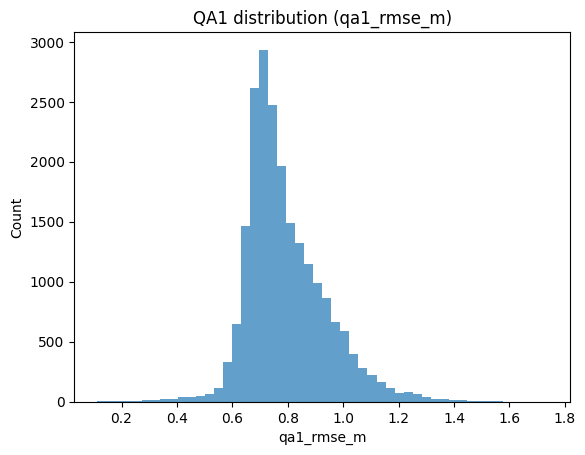

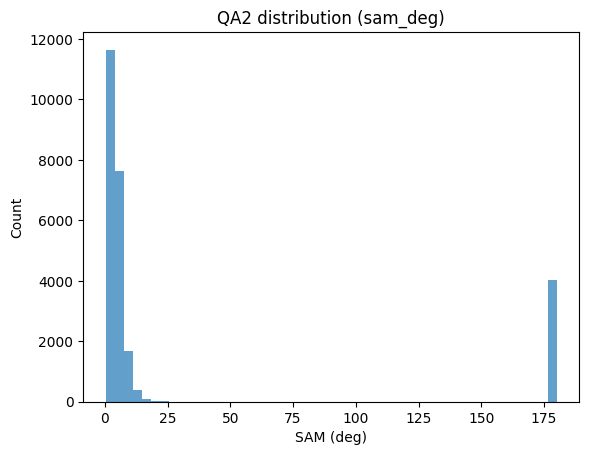

In [11]:
import numpy as np
import matplotlib.pyplot as plt

if not df_result.empty and "verdict" in df_result.columns:
    display(df_result.describe(include='all'))
    
    # 카운트
    cnt = df_result.groupby(["split", "verdict"]).size().unstack(fill_value=0)
    display(cnt)

    # QA1 컬럼명 자동 결정
    qa1_col = "qa1_rmse_lr_px" if "qa1_rmse_lr_px" in df_result.columns else "qa1_rmse_m"
    qa2_col = "qa2_sam_deg" if "qa2_sam_deg" in df_result.columns else None

    # QA1 분포
    qa1_vals = pd.to_numeric(df_result[qa1_col], errors="coerce")
    qa1_vals = qa1_vals[np.isfinite(qa1_vals)]   # inf/NaN 제거
    plt.figure()
    plt.hist(qa1_vals, bins=50, alpha=0.7)
    plt.title(f"QA1 distribution ({qa1_col})")
    plt.xlabel(qa1_col)
    plt.ylabel("Count")
    plt.show()

    # QA2 분포
    if qa2_col:
        qa2_vals = pd.to_numeric(df_result[qa2_col], errors="coerce")
        qa2_vals = qa2_vals[np.isfinite(qa2_vals)]
        plt.figure()
        plt.hist(qa2_vals, bins=50, alpha=0.7)
        plt.title("QA2 distribution (sam_deg)")
        plt.xlabel("SAM (deg)")
        plt.ylabel("Count")
        plt.show()
else:
    print("결과가 비어있습니다. 상단 run_qc 셀을 먼저 실행해 주세요.")



## 7. 노트 & 트러블슈팅

- **GSD 단위**: QA1의 RMSE는 **HR 프레임 픽셀 오차 × HR meters/pixel**로 변환합니다. HR이 SPOT6/7이라면 보통 `~1.5 m/px`를 사용합니다.
- **해상도 차이**: `RESIZE_LR_TO_GT=True`로 LR을 GT 크기로 리사이즈 후 매칭하면 좌표계가 정리되어 추정이 안정적입니다.
- **성능**: `MAX_KP`를 줄이면 빠르지만 민감도가 떨어질 수 있습니다. GPU 메모리가 작다면 1024도 충분한 경우가 많습니다.
- **FlashAttention / compile**: LightGlue는 Torch 2.x에서 자동 최적화 이점을 가집니다. 환경에 따라 추가 속도 향상이 있을 수 있습니다.
- **오류**: 가끔 매칭이 0개일 수 있습니다. 해당 페어는 정합 불가로 간주하고 `drop` 처리합니다.
- **파일 이동/복사**: 안전을 위해 기본은 `none`. 데이터셋을 분기하고 싶으면 `MOVE_MODE='copy'` 추천입니다.

### 설치 이슈 체크리스트
- PyTorch CUDA 빌드가 GPU/드라이버와 맞는지 확인 (`torch.cuda.is_available()`)
- `pip install -e LightGlue` 대신 `pip install --no-build-isolation --no-deps git+https://github.com/cvg/LightGlue.git`가 더 잘 되는 환경도 있습니다.
- OpenCV는 `opencv-python`로 충분합니다. 서버에서 libGL 이슈가 있으면 `apt-get install libgl1` 같은 패키지 추가가 필요할 수 있습니다.


In [12]:
# === Export only "good" pairs from CSV to a new directory ===
from pathlib import Path
import pandas as pd
import shutil
from tqdm import tqdm

# --- 설정값 ---
CSV_PATH = Path("opensr_qc_result.csv")                 # 결과 CSV 경로
SRC_BASE = Path("./zero_cloud_pairs")         # 원본 루트(BASE_DIR)
DST_BASE = Path("./zero_cloud_pairs_good")    # 새 루트(내보낼 위치)
MODE = "copy"   # "copy" | "move" | "dryrun"

# --- CSV 로드 & 검증 ---
df = pd.read_csv(CSV_PATH)
required_cols = {"split", "filename", "verdict"}
missing_cols = required_cols - set(df.columns)
assert not missing_cols, f"CSV에 필요한 컬럼이 없습니다: {missing_cols}"

df_good = df[df["verdict"].astype(str).str.lower() == "good"].copy()
print(f'Good pairs: {len(df_good)} / {len(df)}  ({len(df_good)/max(len(df),1):.1%})')

# --- 내보내기 ---
exported, missing = 0, 0
for split, g in df_good.groupby("split"):
    # 대상 디렉토리 준비
    (DST_BASE / split / "LR").mkdir(parents=True, exist_ok=True)
    (DST_BASE / split / "GT").mkdir(parents=True, exist_ok=True)

    for fname in tqdm(g["filename"], desc=f"[{split}] export", ncols=100):
        src_lr = SRC_BASE / split / "LR" / fname
        src_gt = SRC_BASE / split / "GT" / fname
        dst_lr = DST_BASE / split / "LR" / fname
        dst_gt = DST_BASE / split / "GT" / fname

        if not (src_lr.exists() and src_gt.exists()):
            missing += 1
            continue

        if MODE == "copy":
            shutil.copy2(src_lr, dst_lr)
            shutil.copy2(src_gt, dst_gt)
        elif MODE == "move":
            # 대상 파일이 이미 있으면 덮어씀
            if dst_lr.exists(): dst_lr.unlink()
            if dst_gt.exists(): dst_gt.unlink()
            shutil.move(str(src_lr), str(dst_lr))
            shutil.move(str(src_gt), str(dst_gt))
        elif MODE == "dryrun":
            pass  # 경로만 확인
        else:
            raise ValueError(f"Unknown MODE: {MODE}")

        exported += 1

print(f"\n완료: 내보낸 페어 {exported} / 누락 {missing}")
print(f"저장 위치: {DST_BASE.resolve()}")


Good pairs: 7412 / 25470  (29.1%)


[val] export: 100%|█████████████████████████████████████████████| 757/757 [00:00<00:00, 1246.75it/s]


완료: 내보낸 페어 7412 / 누락 0
저장 위치: /workspace/zero_cloud_mentor/zero_cloud_pairs_good


In [16]:
# === Build experiment datasets (Val 옵션 A, Train 분리) ===
from pathlib import Path
import pandas as pd
import hashlib, shutil, os
from tqdm import tqdm

# ---- 설정 ----
CSV_PATH = Path("opensr_qc_result.csv")    # QC 결과 CSV
SRC_BASE = Path("./zero_cloud_pairs")      # 원본 데이터 루트 (split/LR|GT/filename.png)
DST_ROOT = Path("./exp_zero_cloud_pairs")  # 만들어질 실험용 루트
MODE     = "copy"  # "copy" | "move" | "symlink" | "dryrun"

VAL_MIXED_N = 1000   # 옵션 A: val-mixed 총 개수(권장 1000)

# ---- 유틸 ----
def stable_key(split: str, fname: str) -> str:
    h = hashlib.md5(f"{split}/{fname}".encode("utf-8")).hexdigest()
    return h

def ensure_dirs(root: Path, subset: str):
    (root / subset / "LR").mkdir(parents=True, exist_ok=True)
    (root / subset / "GT").mkdir(parents=True, exist_ok=True)

def transfer_pair(src_base: Path, dst_base: Path, subset: str, split: str, fname: str, mode: str):
    src_lr = src_base / split / "LR" / fname
    src_gt = src_base / split / "GT" / fname
    dst_lr = dst_base / subset / "LR" / fname
    dst_gt = dst_base / subset / "GT" / fname
    if not (src_lr.exists() and src_gt.exists()):
        return False
    if mode == "copy":
        shutil.copy2(src_lr, dst_lr); shutil.copy2(src_gt, dst_gt)
    elif mode == "move":
        if dst_lr.exists(): dst_lr.unlink()
        if dst_gt.exists(): dst_gt.unlink()
        shutil.move(str(src_lr), str(dst_lr)); shutil.move(str(src_gt), str(dst_gt))
    elif mode == "symlink":
        # 심볼릭 링크 (리눅스/맥 권장, 윈도우는 관리자 권한 필요할 수 있음)
        if dst_lr.exists(): dst_lr.unlink()
        if dst_gt.exists(): dst_gt.unlink()
        os.symlink(src_lr, dst_lr); os.symlink(src_gt, dst_gt)
    elif mode == "dryrun":
        pass
    else:
        raise ValueError(f"Unknown MODE: {mode}")
    return True

# ---- CSV 로드 ----
df = pd.read_csv(CSV_PATH)
need = {"split","filename","verdict"}
missing = need - set(df.columns)
assert not missing, f"CSV에 필요한 컬럼 없음: {missing}"

# 소문자 정규화
df["verdict"] = df["verdict"].astype(str).str.lower()
df["split"]   = df["split"].astype(str)

# 통계
df_train = df[df["split"]=="train"].copy()
df_val   = df[df["split"]=="val"].copy()

# train 현황
n_train_total = len(df_train)
n_train_good  = int((df_train["verdict"]=="good").sum())
n_train_drop  = int((df_train["verdict"]=="drop").sum())

# val 현황
n_val_good = int((df_val["verdict"]=="good").sum())
n_val_drop = int((df_val["verdict"]=="drop").sum())
n_val_total = len(df_val)
p_val_good = n_val_good / max(n_val_total,1)

print(f"[train] total={n_train_total}, good={n_train_good}, drop={n_train_drop}")
print(f"[val]   total={n_val_total}, good={n_val_good}, drop={n_val_drop}, good_ratio={p_val_good:.3f}")

# ---- Val 옵션 A: val_mixed / val_clean 구성 ----
good_mixed = round(VAL_MIXED_N * p_val_good)      # ≈ 292
drop_mixed = VAL_MIXED_N - good_mixed             # ≈ 708
assert good_mixed <= n_val_good, "val good 개수가 모자랍니다. VAL_MIXED_N을 줄이세요."
assert drop_mixed <= n_val_drop, "val drop 개수가 모자랍니다. VAL_MIXED_N을 줄이세요."

# deterministic 샘플링을 위해 해시키로 정렬
val_good = df_val[df_val["verdict"]=="good"].copy()
val_drop = df_val[df_val["verdict"]=="drop"].copy()
val_good["key"] = val_good.apply(lambda r: stable_key(r["split"], r["filename"]), axis=1)
val_drop["key"] = val_drop.apply(lambda r: stable_key(r["split"], r["filename"]), axis=1)
val_good = val_good.sort_values("key").reset_index(drop=True)
val_drop = val_drop.sort_values("key").reset_index(drop=True)

val_mixed_good = val_good.iloc[:good_mixed]
val_mixed_drop = val_drop.iloc[:drop_mixed]
val_mixed = pd.concat([val_mixed_good, val_mixed_drop], ignore_index=True)

val_clean = val_good.iloc[good_mixed:]  # 남은 good 전부
print(f"[val_mixed] {len(val_mixed)} (good={len(val_mixed_good)}, drop={len(val_mixed_drop)})")
print(f"[val_clean] {len(val_clean)} (good only)")

# 교집합 체크(겹치면 안 됨)
assert set(zip(val_clean["split"], val_clean["filename"])).isdisjoint(
       set(zip(val_mixed["split"], val_mixed["filename"]))), "val_clean과 val_mixed가 겹칩니다."

# ---- Train 세트 구성 ----
# Train-good-6k: train good 전량(=5925 근처)
train_good6k = df_train[df_train["verdict"]=="good"].copy()
# Train-mix-6k: train 전체에서 5925개 안정적 샘플링
TARGET_6K = min(5925, n_train_total)  # 요청값에 맞춤
df_train_all = df_train.copy()
df_train_all["key"] = df_train_all.apply(lambda r: stable_key(r["split"], r["filename"]), axis=1)
train_mix6k = df_train_all.sort_values("key").head(TARGET_6K).drop(columns=["key"])

# Train-mix-20k: train 전체(20382)
train_mix20k = df_train.copy()

print(f"[train_good6k] {len(train_good6k)} | [train_mix6k] {len(train_mix6k)} | [train_mix20k] {len(train_mix20k)}")

# ---- 내보내기 목록(dict: subset_name -> df) ----
subsets = {
    "val_clean":   val_clean,
    "val_mixed":   val_mixed,
    "train_good6k": train_good6k,
    "train_mix6k":  train_mix6k,
    "train_mix20k": train_mix20k,
}

# ---- 저장(복사/이동/링크) + 매니페스트 기록 ----
DST_ROOT.mkdir(parents=True, exist_ok=True)
export_counts = {}
for subset, df_sub in subsets.items():
    ensure_dirs(DST_ROOT, subset)
    ok = miss = 0
    print(f"\n[{subset}] exporting {len(df_sub)} pairs...")
    for _, r in tqdm(df_sub.iterrows(), total=len(df_sub), ncols=100):
        if transfer_pair(SRC_BASE, DST_ROOT, subset, r["split"], r["filename"], MODE):
            ok += 1
        else:
            miss += 1
    export_counts[subset] = (ok, miss)
    # 매니페스트 저장
    manifest = df_sub[["split","filename","verdict"]].copy()
    manifest.to_csv(DST_ROOT / f"{subset}_manifest.csv", index=False, encoding="utf-8")
    print(f" -> done: ok={ok}, missing={miss} | manifest: {DST_ROOT / f'{subset}_manifest.csv'}")

print("\n요약:")
for k,(ok,miss) in export_counts.items():
    print(f"  {k:14s}  ok={ok:6d}  missing={miss:4d}")
print(f"\n저장 루트: {DST_ROOT.resolve()}\nMODE={MODE}")


[train] total=20382, good=5925, drop=14457
[val]   total=2590, good=757, drop=1833, good_ratio=0.292
[val_mixed] 1000 (good=292, drop=708)
[val_clean] 465 (good only)
[train_good6k] 5925 | [train_mix6k] 5925 | [train_mix20k] 20382

[val_clean] exporting 465 pairs...


100%|███████████████████████████████████████████████████████████| 465/465 [00:00<00:00, 1165.88it/s]


 -> done: ok=465, missing=0 | manifest: exp_zero_cloud_pairs/val_clean_manifest.csv

[val_mixed] exporting 1000 pairs...


100%|█████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1154.26it/s]


 -> done: ok=1000, missing=0 | manifest: exp_zero_cloud_pairs/val_mixed_manifest.csv

[train_good6k] exporting 5925 pairs...


100%|█████████████████████████████████████████████████████████| 5925/5925 [00:05<00:00, 1165.03it/s]


 -> done: ok=5925, missing=0 | manifest: exp_zero_cloud_pairs/train_good6k_manifest.csv

[train_mix6k] exporting 5925 pairs...


100%|██████████████████████████████████████████████████████████| 5925/5925 [00:06<00:00, 875.38it/s]


 -> done: ok=5925, missing=0 | manifest: exp_zero_cloud_pairs/train_mix6k_manifest.csv

[train_mix20k] exporting 20382 pairs...


100%|███████████████████████████████████████████████████████| 20382/20382 [00:20<00:00, 1012.16it/s]

 -> done: ok=20382, missing=0 | manifest: exp_zero_cloud_pairs/train_mix20k_manifest.csv

요약:
  val_clean       ok=   465  missing=   0
  val_mixed       ok=  1000  missing=   0
  train_good6k    ok=  5925  missing=   0
  train_mix6k     ok=  5925  missing=   0
  train_mix20k    ok= 20382  missing=   0

저장 루트: /workspace/zero_cloud_mentor/exp_zero_cloud_pairs
MODE=copy


In [14]:
# === 시각화 준비: 매칭/정합/방사 함수 + 유틸 ===
from pathlib import Path
from typing import Dict, Tuple, Optional
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import torch
torch.set_grad_enabled(False)
from lightglue import LightGlue, DISK
from lightglue.utils import rbd
from skimage.exposure import match_histograms

# ----- 경로/파라미터 -----
CSV_PATH   = Path("./opensr_qc_result.csv")             # 결과 CSV
SRC_BASE   = Path("./zero_cloud_pairs")     # 원본 루트(BASE_DIR)
GEOM_MODEL = "homography"   # "homography" | "affine" | "similarity"
HR_GSD_MPP = 2.5            # HR 해상도(m/px) 예: 2.5(NAIP/SPOT) / 5.0(VENµS) / (자료에 맞게 변경)
LR_GSD_MPP = 10.0           # LR 해상도(m/px)  예: Sentinel-2 = 10
QA1_THRESH_LR_PX = 0.75     # 논문 기준: QA1 임계 (LR 픽셀)
QA2_THRESH_DEG   = 5.0      # 논문 기준: QA2 임계 (도)
DISP_GATE_LR_PX  = 3.0      # 30m = 3 LR px 이상 매칭은 제거
RANSAC_HR_PX     = DISP_GATE_LR_PX * (LR_GSD_MPP / HR_GSD_MPP)  # HR-픽셀 도메인으로 환산
MAX_KP           = 4096     # 키포인트 많이 잡아 시각화 안정화
DEVICE           = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- 모델 초기화 (한 번만) -----
extractor = DISK(max_num_keypoints=MAX_KP).eval().to(DEVICE)
matcher   = LightGlue(features='disk').eval().to(DEVICE)

def to_tensor_image(img_bgr: np.ndarray, device: torch.device) -> torch.Tensor:
    """cv2 BGR uint8 -> torch.FloatTensor [3,H,W], RGB, [0,1]"""
    if img_bgr.ndim == 2:
        img_bgr = cv2.cvtColor(img_bgr, cv2.COLOR_GRAY2BGR)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    ten = torch.from_numpy(img_rgb).permute(2, 0, 1).float() / 255.0
    return ten.to(device, non_blocking=True)

def _fit_model(src_pts, dst_pts, model="homography", ransac_px=6.0, max_iters=5000):
    if len(src_pts) < 4:
        return None, None
    if model == "homography":
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,
                                     ransacReprojThreshold=ransac_px, maxIters=int(max_iters))
        if H is None or mask is None: return None, None
        return H, mask.ravel().astype(bool)
    elif model == "affine":
        M, mask = cv2.estimateAffine2D(src_pts, dst_pts, method=cv2.RANSAC,
                                       ransacReprojThreshold=ransac_px, maxIters=int(max_iters), confidence=0.999)
        if M is None or mask is None: return None, None
        return M, mask.ravel().astype(bool)
    else: # similarity
        M, mask = cv2.estimateAffinePartial2D(src_pts, dst_pts, method=cv2.RANSAC,
                                              ransacReprojThreshold=ransac_px, maxIters=int(max_iters), confidence=0.999)
        if M is None or mask is None: return None, None
        return M, mask.ravel().astype(bool)

def _warp_general(img: np.ndarray, M: np.ndarray, out_hw: Tuple[int,int]) -> np.ndarray:
    H, W = out_hw
    if M.shape == (3,3):
        return cv2.warpPerspective(img, M, (W, H), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT101)
    else:
        return cv2.warpAffine(img, M, (W, H), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT101)

def spectral_angle_map(a_rgb: np.ndarray, b_rgb: np.ndarray, eps: float=1e-8) -> np.ndarray:
    """각 픽셀 스펙트럼 각도(도). a/b: [H,W,3] RGB float32"""
    A = a_rgb.reshape(-1,3)
    B = b_rgb.reshape(-1,3)
    na = np.linalg.norm(A, axis=1)
    nb = np.linalg.norm(B, axis=1)
    valid = (na>eps) & (nb>eps)
    cosang = np.empty_like(na); cosang[:] = np.nan
    cosang[valid] = (A[valid]*B[valid]).sum(1) / (na[valid]*nb[valid] + eps)
    cosang = np.clip(cosang, -1.0, 1.0, out=cosang, where=np.isfinite(cosang))
    ang = np.degrees(np.arccos(cosang))
    return ang.reshape(a_rgb.shape[:2])

def evaluate_and_visualize(split:str, filename:str,
                           geom_model:str=GEOM_MODEL,
                           ransac_hr_px:float=RANSAC_HR_PX,
                           downscale_sam:float=0.5,
                           show=True) -> Dict:
    """한 샘플에 대해: 매칭/정합→QA1·QA2 재계산, 오버레이/잔차/ SAM 맵 시각화"""
    gt_path = SRC_BASE / split / "GT" / filename
    lr_path = SRC_BASE / split / "LR" / filename
    if not (gt_path.exists() and lr_path.exists()):
        raise FileNotFoundError(f"missing pair: {gt_path.name}")

    img_gt = cv2.imread(str(gt_path), cv2.IMREAD_COLOR)
    img_lr = cv2.imread(str(lr_path), cv2.IMREAD_COLOR)
    Ht, Wt = img_gt.shape[:2]
    if img_lr.shape[:2] != img_gt.shape[:2]:
        img_lr_r = cv2.resize(img_lr, (Wt, Ht), interpolation=cv2.INTER_LINEAR)
    else:
        img_lr_r = img_lr

    # 특징 추출/매칭
    ten_lr = to_tensor_image(img_lr_r, DEVICE)
    ten_gt = to_tensor_image(img_gt,   DEVICE)
    feats_lr = extractor.extract(ten_lr)
    feats_gt = extractor.extract(ten_gt)
    matches  = matcher({'image0': feats_lr, 'image1': feats_gt})
    feats_lr, feats_gt, matches = [rbd(x) for x in [feats_lr, feats_gt, matches]]
    m = matches["matches"]
    kps_lr = feats_lr['keypoints'].detach().cpu().numpy()
    kps_gt = feats_gt['keypoints'].detach().cpu().numpy()

    if m.numel() == 0:
        reason = "no matches"
        if show:
            _quick_panel_noalign(img_gt, img_lr_r, title=f"{split}/{filename} | FAIL: {reason}")
        return dict(ok=False, reason=reason)

    idx_lr = m[:,0].detach().cpu().numpy()
    idx_gt = m[:,1].detach().cpu().numpy()
    pts_lr = kps_lr[idx_lr]
    pts_gt = kps_gt[idx_gt]

    # 3 LR px 게이트 (HR-픽셀로 환산한 허용치)
    gate_hr_px = DISP_GATE_LR_PX * (LR_GSD_MPP / HR_GSD_MPP)
    d0 = np.linalg.norm(pts_lr - pts_gt, axis=1)
    keep = d0 <= gate_hr_px
    if not np.any(keep):
        reason = f"all matches > {DISP_GATE_LR_PX:.1f} LR px"
        if show:
            _quick_panel_noalign(img_gt, img_lr_r, title=f"{split}/{filename} | FAIL: {reason}")
        return dict(ok=False, reason=reason)
    pts_lr, pts_gt = pts_lr[keep], pts_gt[keep]

    # RANSAC
    M, inliers = _fit_model(pts_lr, pts_gt, model=geom_model, ransac_px=ransac_hr_px)
    if M is None or inliers is None or inliers.sum()<4:
        reason = "ransac failed"
        if show:
            _quick_panel_noalign(img_gt, img_lr_r, title=f"{split}/{filename} | FAIL: {reason}")
        return dict(ok=False, reason=reason)

    in_lr = pts_lr[inliers]
    in_gt = pts_gt[inliers]

    # QA1: RMSE in LR px
    if M.shape == (3,3):
        src_h = cv2.convertPointsToHomogeneous(in_lr).reshape(-1,3)
        pred  = (src_h @ M.T)
        pred  = pred[:,:2] / (pred[:,2:3] + 1e-8)
    else:
        ones = np.ones((in_lr.shape[0],1), np.float32)
        src_h = np.hstack([in_lr.astype(np.float32), ones])
        pred  = (src_h @ M.T)
    residual_hr_px = np.linalg.norm(pred - in_gt.astype(np.float32), axis=1)
    residual_lr_px = residual_hr_px * (HR_GSD_MPP / LR_GSD_MPP)
    qa1_rmse_lr_px = float(np.sqrt(np.mean(np.square(residual_lr_px))))

    # QA2: 워핑 + 히스토그램 매칭 + SAM 맵
    warped_lr = _warp_general(img_lr_r, M, (Ht, Wt))
    matched   = match_histograms(warped_lr, img_gt, channel_axis=-1)

    # SAM map (RGB 기준), 보기 편하게 다운스케일
    if downscale_sam != 1.0:
        tgt_size = (int(Wt*downscale_sam), int(Ht*downscale_sam))
        A = cv2.resize(cv2.cvtColor(matched, cv2.COLOR_BGR2RGB).astype(np.float32), tgt_size, interpolation=cv2.INTER_AREA)
        B = cv2.resize(cv2.cvtColor(img_gt,  cv2.COLOR_BGR2RGB).astype(np.float32), tgt_size, interpolation=cv2.INTER_AREA)
    else:
        A = cv2.cvtColor(matched, cv2.COLOR_BGR2RGB).astype(np.float32)
        B = cv2.cvtColor(img_gt,  cv2.COLOR_BGR2RGB).astype(np.float32)
    sam_map = spectral_angle_map(A, B)
    qa2_sam_deg = float(np.nanmean(sam_map))

    qa1_pass = qa1_rmse_lr_px <= QA1_THRESH_LR_PX
    qa2_pass = qa2_sam_deg   <= QA2_THRESH_DEG
    verdict  = "good" if (qa1_pass and qa2_pass) else "drop"

    if show:
        _panel_visualize(img_gt, img_lr_r, matched, in_lr, in_gt, pred,
                         sam_map, qa1_rmse_lr_px, qa1_pass, qa2_sam_deg, qa2_pass,
                         title=f"{split}/{filename}  → {verdict} | QA1={qa1_rmse_lr_px:.3f} LRpx ({'PASS' if qa1_pass else 'FAIL'}) | QA2={qa2_sam_deg:.2f}° ({'PASS' if qa2_pass else 'FAIL'})")
    return dict(ok=(verdict=="good"),
                qa1_rmse_lr_px=qa1_rmse_lr_px, qa1_pass=qa1_pass,
                qa2_sam_deg=qa2_sam_deg, qa2_pass=qa2_pass,
                n_inliers=int(inliers.sum()), n_matches=int(len(pts_lr)))

def _quick_panel_noalign(img_gt, img_lr_r, title=""):
    fig, axs = plt.subplots(1,3, figsize=(14,4))
    axs[0].imshow(cv2.cvtColor(img_gt,  cv2.COLOR_BGR2RGB)); axs[0].set_title("GT"); axs[0].axis('off')
    axs[1].imshow(cv2.cvtColor(img_lr_r, cv2.COLOR_BGR2RGB)); axs[1].set_title("LR (resized)"); axs[1].axis('off')
    blend = cv2.addWeighted(img_gt, 0.5, img_lr_r, 0.5, 0)
    axs[2].imshow(cv2.cvtColor(blend, cv2.COLOR_BGR2RGB)); axs[2].set_title("Blend"); axs[2].axis('off')
    fig.suptitle(title, fontsize=12)
    plt.tight_layout(); plt.show()

def _panel_visualize(img_gt, img_lr_r, matched_lr, in_lr, in_gt, pred, sam_map,
                     qa1_rmse_lr_px, qa1_pass, qa2_sam_deg, qa2_pass, title=""):
    """좌: 오버레이, 중: 잔차 벡터(퀴버), 우: SAM 맵"""
    H, W = img_gt.shape[:2]
    blend = cv2.addWeighted(img_gt, 0.5, matched_lr, 0.5, 0)

    fig, axs = plt.subplots(1,3, figsize=(18,5))

    # 1) Blend overlay
    axs[0].imshow(cv2.cvtColor(blend, cv2.COLOR_BGR2RGB))
    axs[0].set_title("GT ⊕ Warped LR (hist-match)")
    axs[0].axis('off')

    # 2) Residual vectors (HR px 기준 화살표, 라벨은 LR px RMSE)
    axs[1].imshow(cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB))
    if len(in_lr) > 0:
        dx = pred[:,0] - in_gt[:,0]
        dy = pred[:,1] - in_gt[:,1]
        axs[1].quiver(in_gt[:,0], in_gt[:,1], dx, dy, angles='xy', scale_units='xy', scale=1, width=0.002, color='lime')
    axs[1].set_title(f"Reprojection residuals (RMSE={qa1_rmse_lr_px:.3f} LRpx | {'PASS' if qa1_pass else 'FAIL'})")
    axs[1].axis('off')

    # 3) SAM map
    im = axs[2].imshow(sam_map, cmap='magma', vmin=0, vmax=15)
    axs[2].set_title(f"SAM map (mean={qa2_sam_deg:.2f}° | {'PASS' if qa2_pass else 'FAIL'})")
    axs[2].axis('off')
    fig.colorbar(im, ax=axs[2], fraction=0.046, pad=0.04, label='deg')

    fig.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()


good=7412, drop=18058

=== GOOD examples (3) ===


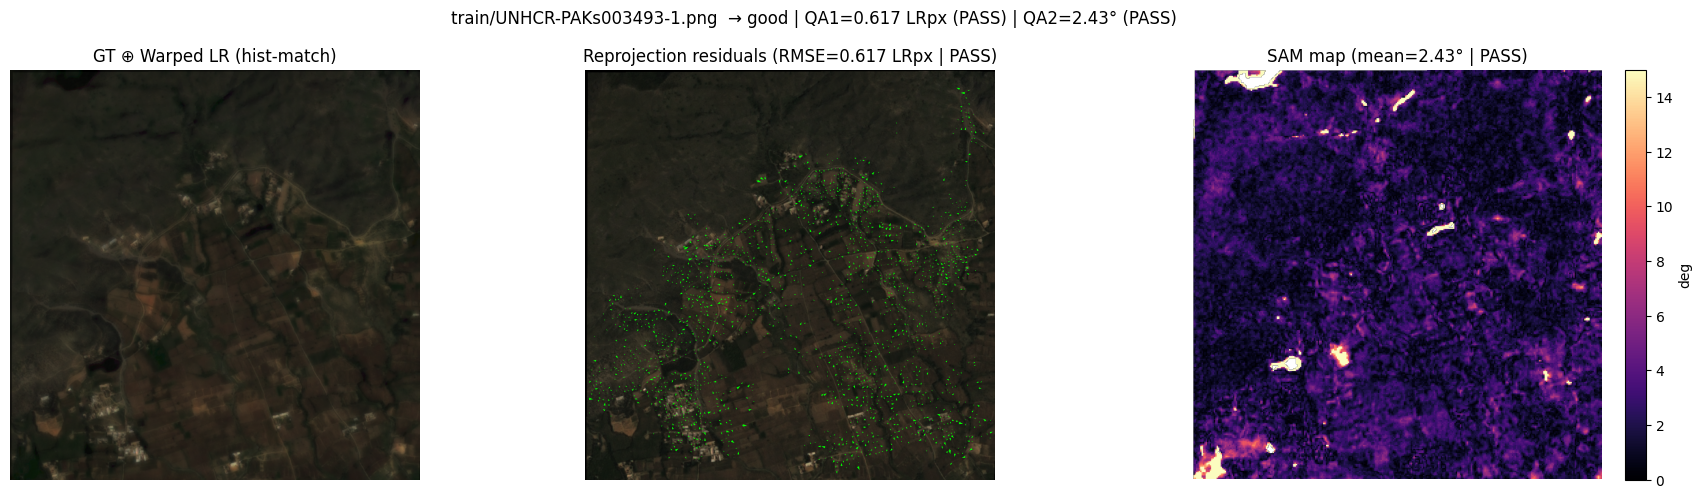

- train/UNHCR-PAKs003493-1.png → original verdict=good | recomputed: good


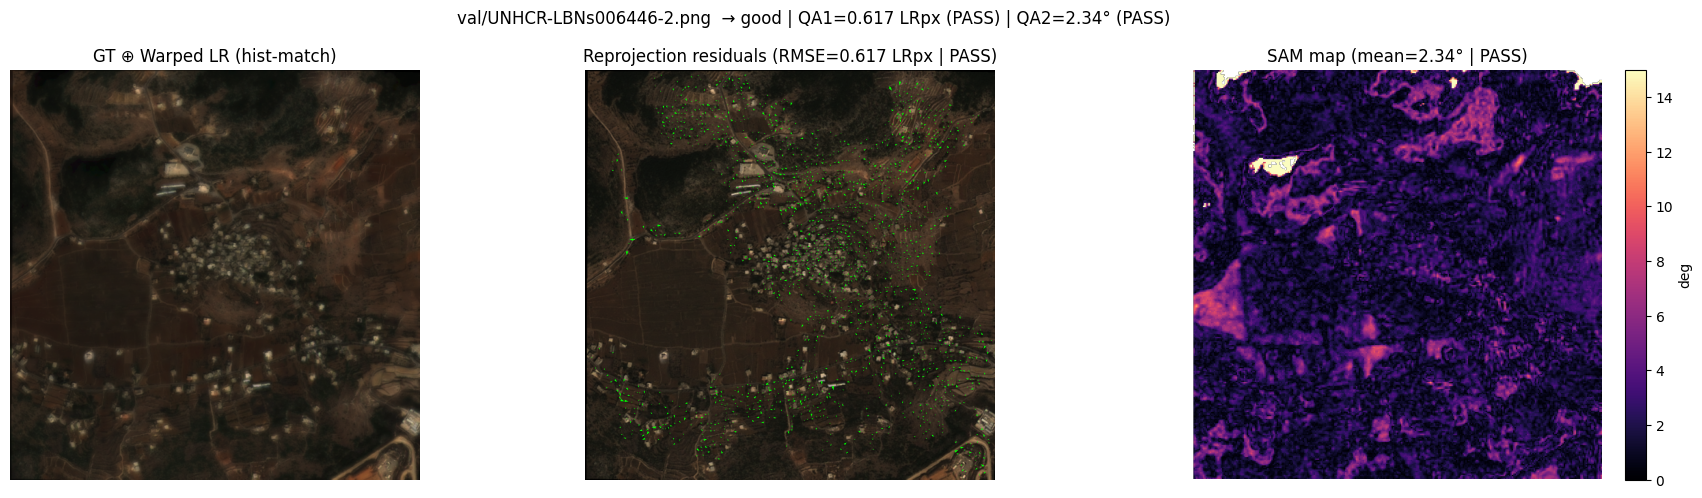

- val/UNHCR-LBNs006446-2.png → original verdict=good | recomputed: good


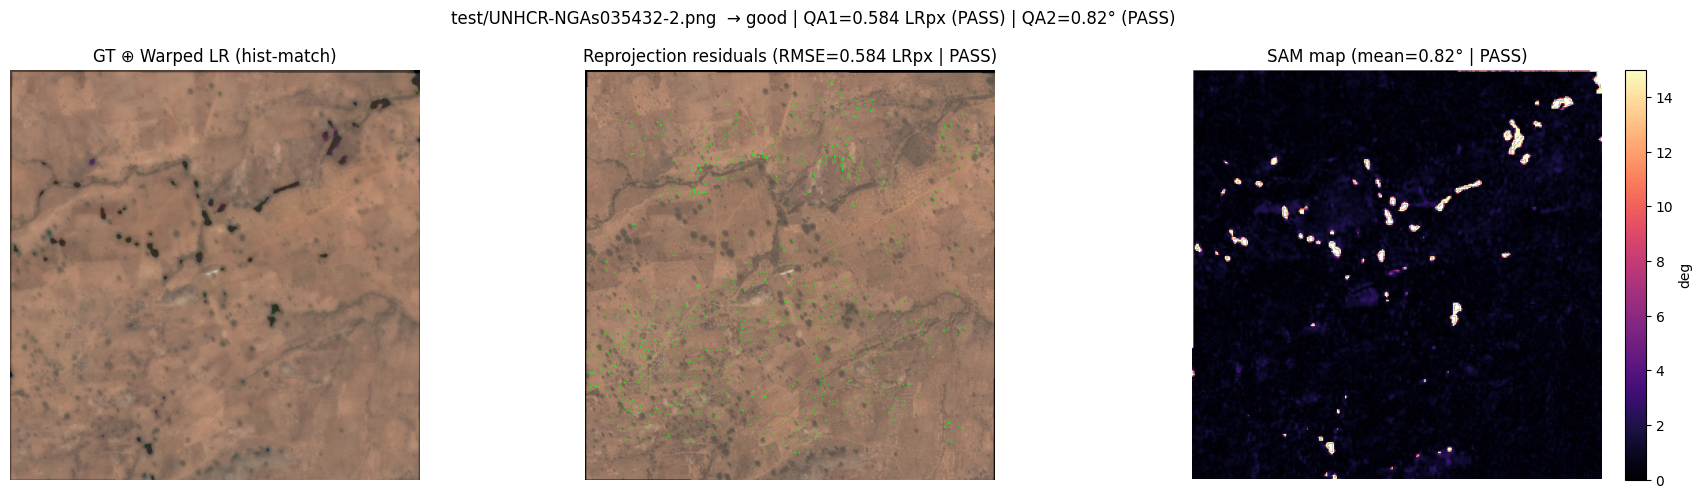

- test/UNHCR-NGAs035432-2.png → original verdict=good | recomputed: good

=== DROP examples (3) ===


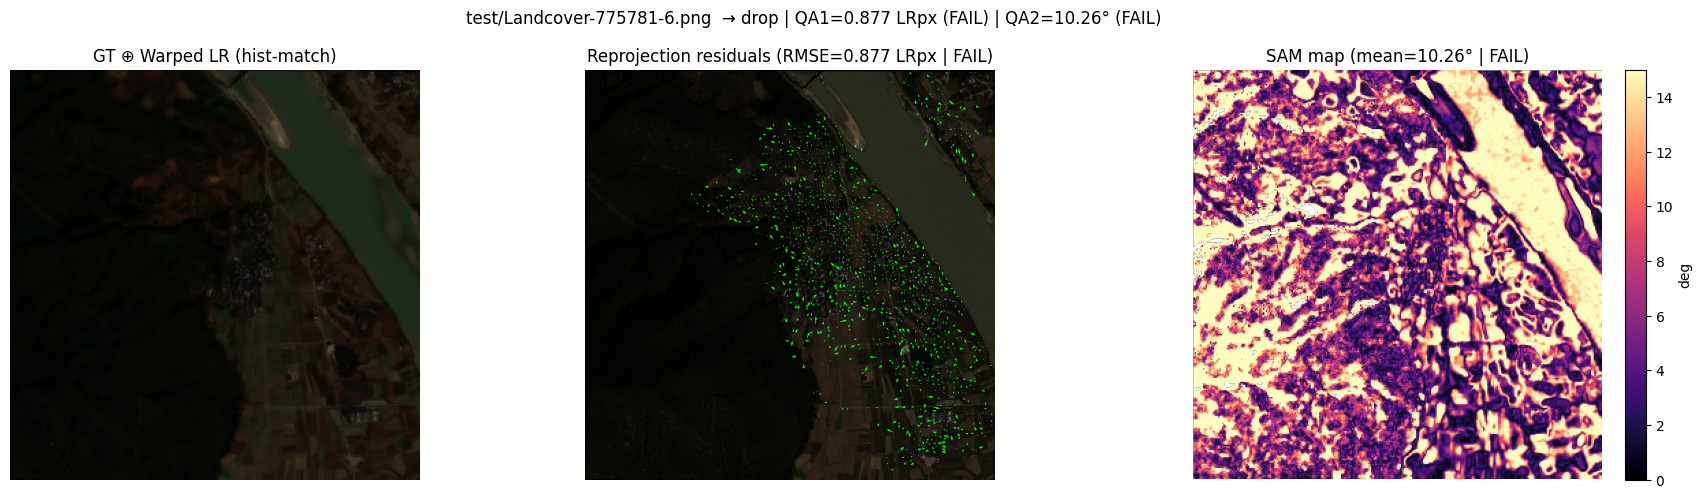

- test/Landcover-775781-6.png → original verdict=drop | recomputed: drop
  reasons: QA1 FAIL (RMSE=0.877 > 0.75); QA2 FAIL (SAM=10.26° > 5.0°)


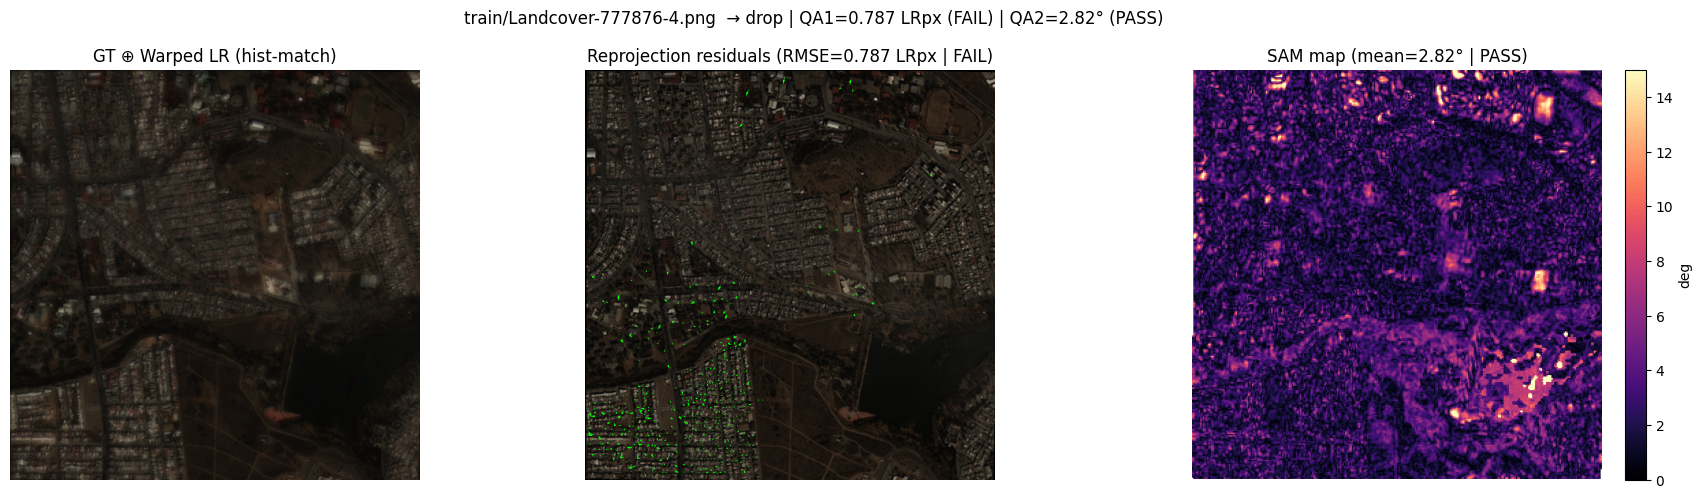

- train/Landcover-777876-4.png → original verdict=drop | recomputed: drop
  reasons: QA1 FAIL (RMSE=0.787 > 0.75)


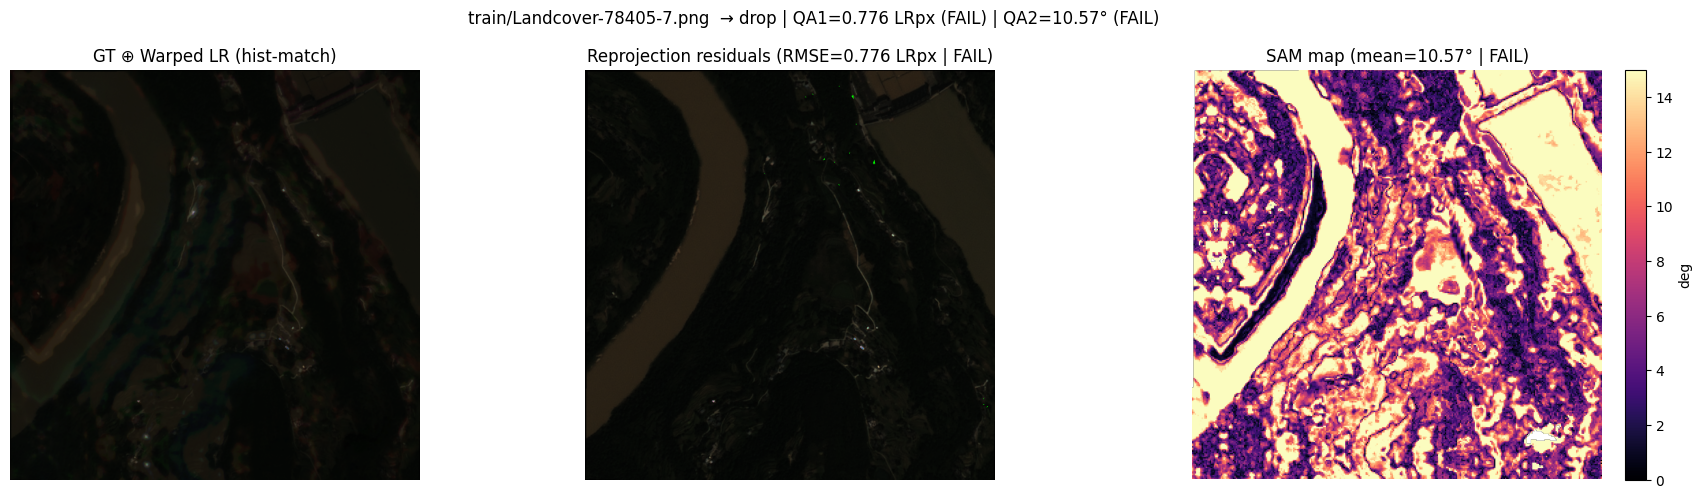

- train/Landcover-78405-7.png → original verdict=drop | recomputed: drop
  reasons: QA1 FAIL (RMSE=0.776 > 0.75); QA2 FAIL (SAM=10.57° > 5.0°)


In [15]:
# === CSV 기준으로 split 무시하고 good/drop 예시 시각화 ===
import random
random.seed(0)

df = pd.read_csv(CSV_PATH)
assert {"split","filename","verdict"} <= set(df.columns), "CSV에 split/filename/verdict가 필요합니다."

# 예시 개수 설정 (원하면 숫자만 바꿔)
N_GOOD = 3
N_DROP = 3

df_good = df[df["verdict"].astype(str).str.lower()=="good"]
df_drop = df[df["verdict"].astype(str).str.lower()=="drop"]

print(f"good={len(df_good)}, drop={len(df_drop)}")

picked_good = df_good.sample(min(N_GOOD, len(df_good)), random_state=0) if len(df_good)>0 else pd.DataFrame(columns=df.columns)
picked_drop = df_drop.sample(min(N_DROP, len(df_drop)), random_state=1) if len(df_drop)>0 else pd.DataFrame(columns=df.columns)

def show_rows(rows, tag):
    print(f"\n=== {tag} examples ({len(rows)}) ===")
    for _, r in rows.iterrows():
        try:
            res = evaluate_and_visualize(r["split"], r["filename"], show=True)
            # 사유 출력 (현재 설정 기준 재계산 결과)
            reasons = []
            if "qa1_rmse_lr_px" in res:
                if not res["qa1_pass"]:
                    reasons.append(f"QA1 FAIL (RMSE={res['qa1_rmse_lr_px']:.3f} > {QA1_THRESH_LR_PX})")
            if "qa2_sam_deg" in res:
                if not res["qa2_pass"]:
                    reasons.append(f"QA2 FAIL (SAM={res['qa2_sam_deg']:.2f}° > {QA2_THRESH_DEG}°)")
            if not reasons and not res.get("ok", False):
                reasons.append(res.get("reason","unknown"))
            print(f"- {r['split']}/{r['filename']} → original verdict={r['verdict']} | recomputed: {'good' if res.get('ok', False) else 'drop'}")
            if reasons:
                print("  reasons:", "; ".join(reasons))
        except Exception as e:
            print(f"- {r['split']}/{r['filename']}  [error: {e}]")

show_rows(picked_good, "GOOD")
show_rows(picked_drop, "DROP")
